<a href="https://colab.research.google.com/github/LIONELSON/ZMI_test_schools/blob/master/Copie_de_ecole_medicale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Using Scikit-learn

To get started, let's make sure that all libraries we need are installed by running the next code cell.

Hint: to run a cell, click on it and press `Ctrl+Enter`. Alternatively

In [ ]:
!pip install numpy pandas scikit-learn seaborn==0.9.0

Next, go to kaggle and download the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data) to your computer. Once you extract the files, you should find a file called `data.csv`. Run the next cell and upload this file so that it is available to Colab.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


## Pandas

Pandas is very useful for manipulating tabular data. We start by importing the data using Pandas.

For more information on pandas, read their [documentation](https://pandas.pydata.org/).



In [6]:
import pandas as pd

dataset = pd.read_csv('data.csv')

# Print useful stats about the dataset
print("Number of total entries: ", len(dataset))
print("")

print("Entries per category:")
print(dataset["diagnosis"].value_counts())

dataset.head() # Explore the first 5 rows of the data

Number of total entries:  569

Entries per category:
B    357
M    212
Name: diagnosis, dtype: int64


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Matplotlib

We will now make a pie chart of the diagnosis distribution using [matplotlib](https://matplotlib.org/)'s pie chart function.

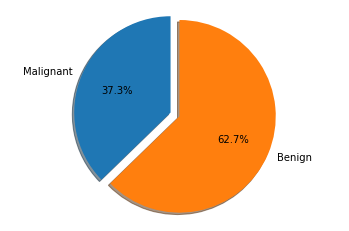

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Order the data by class, this is not necessary but can be useful
dataset = dataset.sort_values(by='diagnosis', ascending=False)

n_benign = dataset["diagnosis"].value_counts().values[0]
n_malig = dataset["diagnosis"].value_counts().values[1]

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Malignant', 'Benign'
sizes = [n_malig, n_benign]
explode = (0, 0.1)  # only "explode" the 2nd slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Seaborn

We now use [SeaBorn](https://seaborn.pydata.org/) to create rich and informative plots directly from pandas dataframes.



### Tip 

If you get the following error using Seaborn 

`AttributeError: module 'seaborn' has no attribute 'relplot'`

Try resetting the runtime in `Runtime > Restart Runtime` and starting over.  See [this post](https://stackoverflow.com/questions/51226306/google-colab-not-updating-package) for more details.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


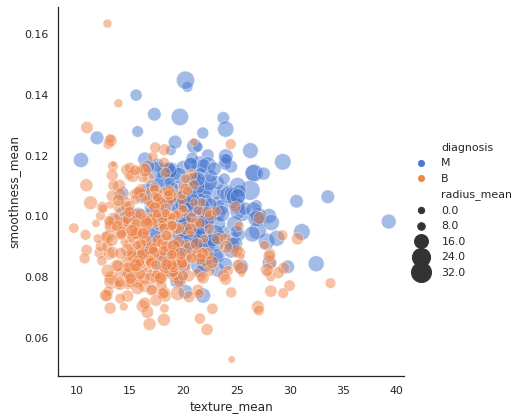

In [8]:
import seaborn as sns

sns.set(style="white")

# Plot texture against smoothness 
# with radius and class
sns.relplot(x="texture_mean", 
            y="smoothness_mean", 
            hue="diagnosis", 
            size="radius_mean",
            sizes=(40, 400), 
            alpha=.5, palette="muted",
            height=6, data=dataset)


Another example of SeaBorn plots for easy data visualization:

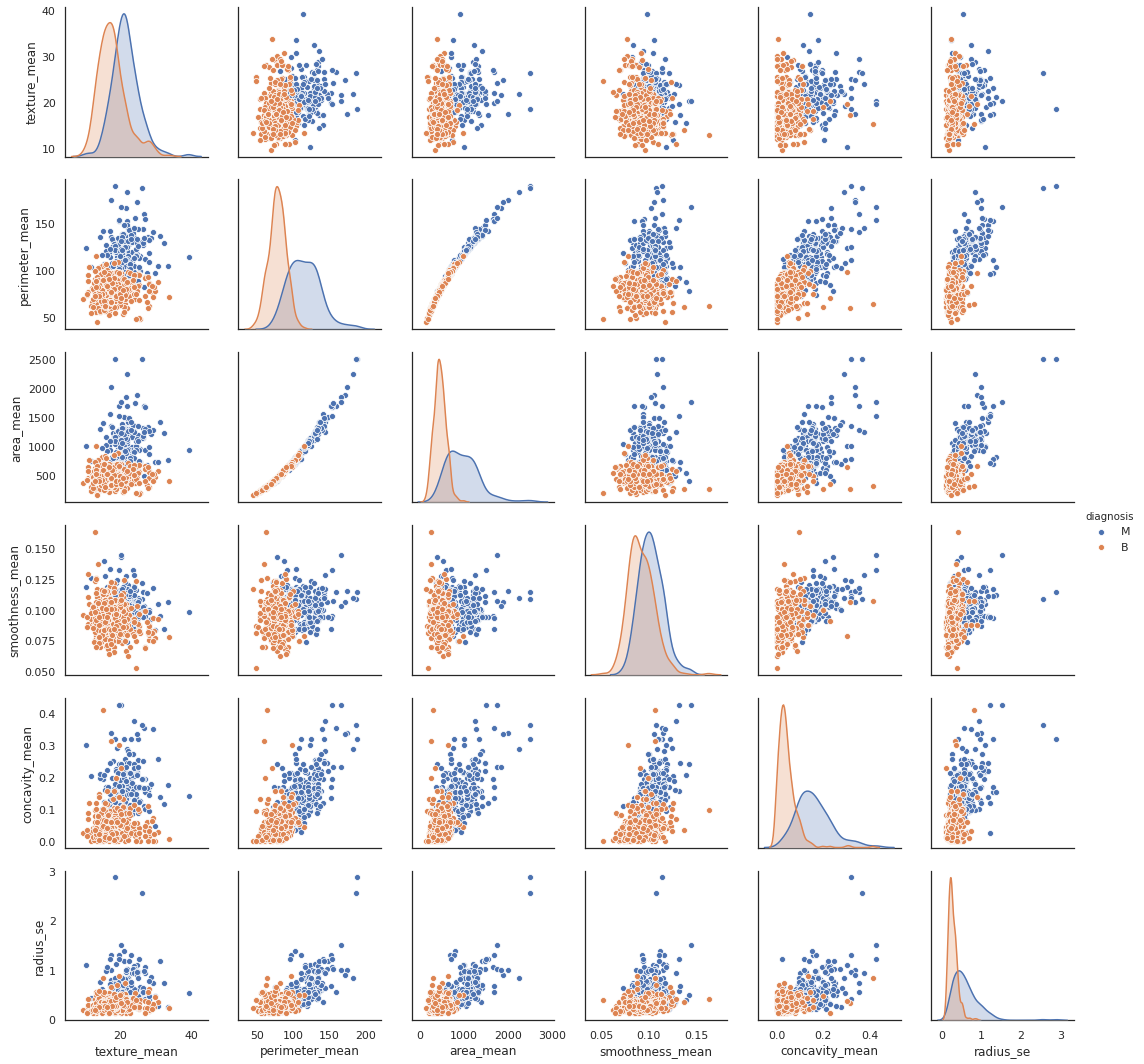

In [12]:
# Select specific indices to look for correlations

col_idx = [1,3,4,5,6,8,12]
columns = dataset.columns[col_idx]
sns.pairplot(dataset[columns], 
             hue="diagnosis")

## Numpy

We will now use [numpy](https://docs.scipy.org/doc/numpy-1.13.0/user/index.html) to transform the data from the pandas dataframes to allow for easier processing of the data and to make it compatible with scikit-learn. 

In [13]:
import numpy as np

n_columns = len(dataset.columns)

# Convert data to ndarray
# Be careful not to include your labels in your data!
X = np.asarray(dataset.iloc[:, 2:n_columns-1])

# Labels (binary), True is Malignant, False is Benign
y = np.asarray(dataset.iloc[:, 1] == 'M')


idx = np.random.randint(len(dataset))

print('Sample datapoint #', idx)
print('\nData :')
print(X[idx,:])
print('\nLabel :', y[idx])

Sample datapoint # 242

Data :
[1.189e+01 2.117e+01 7.639e+01 4.338e+02 9.773e-02 8.120e-02 2.555e-02
 2.179e-02 2.019e-01 6.290e-02 2.747e-01 1.203e+00 1.930e+00 1.953e+01
 9.895e-03 3.053e-02 1.630e-02 9.276e-03 2.258e-02 2.272e-03 1.305e+01
 2.721e+01 8.509e+01 5.229e+02 1.426e-01 2.187e-01 1.164e-01 8.263e-02
 3.075e-01 7.351e-02]

Label : False


## Scikit-Learn

We will now use [scikit-learn](https://scikit-learn.org/stable/) to leverage machine-learning algorithms to classify our data.

We will start by fitting the data naively on the entire dataset. We are then seeing how we score on the entire dataset. Here we are using [logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

This method is not recommended, as we are evaluating our model based on examples seen during training of our model.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X,y)

y_pred = logreg.predict(X)
print("Accuracy: {:.1f} %".format(accuracy_score(y, y_pred)*100))

Accuracy: 96.0 %


## Cross-Validation

Let's look at splitting our data in to training and testing sets and perform cross-validation. In this example, we will use [stratified splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html), which will ensure that the proportions of classes are kept balanced accross splits. Each split is taken randomly and there can be overlaps between splits (they are not guaranteed to be unique, but it is very unlikely that they would not be).

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

acc_tot = 0
n_splits = 3

sss = StratifiedShuffleSplit(n_splits=n_splits, 
                             test_size=0.3, 
                             random_state=42)

logreg = LogisticRegression(solver='liblinear')

for train_index, test_index in sss.split(X, y):
    
    X_train = X[train_index]
    y_train = y[train_index]
    
    X_test = X[test_index]
    y_test = y[test_index]
    
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    acc_tot += acc
    

print("Average Accuracy: {:.1f} %".format(acc_tot/n_splits*100))

Average Accuracy: 94.5 %


Let's combine everything in a function for portability, that we will call `fit_model`. We will also give this function the ability to do some preprocessing, in this case we will scale our features to be centered about 0 and have variance of 1. Refer to the [StandardScaler]() documentation for more information.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


def fit_model(X,y, n_splits, scale=False, verbose=True):
    
    ''' 
    X: ndarray
        contains the features to be classified
    
    y: ndarray, contains the labels in binary form
    
    n_splits : int
        number of splits to perform in cross-validation
        
    scale (optional) : bool
        scale the input data using StandardScaler method

    verbose (optional) : bool
        specify if results should be printed or not
        
    
    '''
    
    acc_tot = 0
    
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)
    logreg = LogisticRegression(solver='liblinear')
    scaler = StandardScaler()

    for split, (train_index, test_index) in enumerate(sss.split(X, y)):
        
        if scale:
            
            X_train = scaler.fit_transform(X[train_index])
            X_test = scaler.transform(X[test_index])
        
        else:
            
            X_train = X[train_index]
            X_test = X[test_index]
            
        y_train = y[train_index]
        y_test = y[test_index]

        logreg.fit(X_train,y_train)

        y_pred = logreg.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        if verbose:

            print("Split ", split)
            print("Accuracy : ", acc)
            print("")
        
        acc_tot += acc
    print("Number of splits used :", n_splits)
    print("Average Accuracy: {:.1f} %".format(acc_tot/n_splits*100))

In [ ]:
fit_model(X,y, n_splits=30, scale=False, verbose=False)

Number of splits used : 30
Average Accuracy: 94.8 %


In [ ]:
fit_model(X,y, n_splits=30, scale=True, verbose=False)

Number of splits used : 30
Average Accuracy: 97.4 %


Let's look at what StratifiedShuffleSplit looks like.

For more strategies of splits, refer to this [post](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

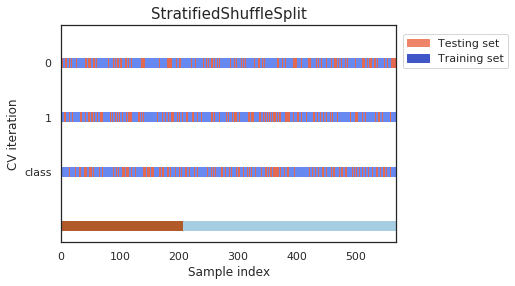

In [ ]:
from matplotlib.patches import Patch
np.random.seed(1337)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits-1)) + ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.8, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

    
    return ax

fig, ax = plt.subplots()
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
_ = plot_cv_indices(cv, X, y, y, ax, n_splits)
